# Social Media Analysis on Missing and Murdered Indigenous Women/ People using Big Data Analytics

### Libraries

In [1]:
import json
import pandas as pd
import csv
import re
import string
import preprocessor as p
import os
import time
from operator import itemgetter 
import glob
import numpy as np
import warnings
import heapq
warnings.filterwarnings('ignore')

In [3]:
%autosave 180

Autosaving every 180 seconds


In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from PIL import Image

import spacy
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score

pd.options.display.max_colwidth = 600

import string

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import contractions

## Data Ingestion

### Writing JSON data from postman to a dataframe

In [ ]:
json_folder_path = os.path.basename("/2015to2020")
# In order to get the list of all files that ends with ".json"
# we will get list of all files, and take only the ones that ends with "json"
json_files = [ x for x in os.listdir(json_folder_path) if x.endswith("json") ]

i=0
for json_file in json_files:
    i = i+1
    json_file_path = os.path.join(json_folder_path, json_file)
    f = open(json_file_path, encoding="utf8")
    data = json.load(f)
    data_fields = data['data']
    places_fields = data['includes']['places']
    tweets_frame = pd.DataFrame()
    tweets_frame['id'] = list(map(lambda data_fields: data_fields['id'] if data_fields['id'] != None else None, data_fields))
    tweets_frame['text'] = list(map(lambda data_fields: data_fields['text'] if data_fields['text'] != None else None, data_fields))
    tweets_frame['created_at'] = list(map(lambda data_fields: data_fields['created_at'] if data_fields['created_at'] != None else None, data_fields))
    tweets_frame['source'] = list(map(lambda data_fields: data_fields['source'] if data_fields['source'] != None else None, data_fields))
    tweets_frame['geo'] = list(map(lambda data_fields: data_fields.get('geo') if data_fields.get('geo') != None else None, data_fields))
    
    tweets_frame['retweet_count'] = list(map(lambda data_fields: data_fields['public_metrics']['retweet_count'] if data_fields['public_metrics']['retweet_count'] != None else None, data_fields))
    tweets_frame['reply_count'] = list(map(lambda data_fields: data_fields['public_metrics']['reply_count'] if data_fields['public_metrics']['reply_count'] != None else None, data_fields))
    tweets_frame['like_count'] = list(map(lambda data_fields: data_fields['public_metrics']['like_count'] if data_fields['public_metrics']['like_count'] != None else None, data_fields))  
    #tweets_frame.to_csv('./tweet_df1/csv'+str(i)+'.csv',index=False)
    user_Loc_Frame = pd.DataFrame()
    user_Loc_Frame['full_name'] = list(map(lambda places_fields: places_fields['full_name'] if places_fields['full_name'] != None else None, places_fields))
    user_Loc_Frame['country'] = list(map(lambda places_fields: places_fields['country'] if places_fields['country'] != None else None, places_fields))
    user_Loc_Frame['country_code'] = list(map(lambda places_fields: places_fields['country_code'] if places_fields['country_code'] != None else None, places_fields))
    user_Loc_Frame['longitude'] = list(map(lambda places_fields: places_fields['geo']['bbox'][0] if places_fields['geo'] != None else None, places_fields))
    user_Loc_Frame['latitude'] = list(map(lambda places_fields: places_fields['geo']['bbox'][1] if places_fields['geo'] != None else None, places_fields))
    user_Loc_Frame.to_csv('./user_loc_df1/csv'+str(i)+'.csv',index=False)
    f.close()

In [ ]:
#Creating tweets_frame dataframe
fileList=glob.glob("./tweet_df1/*.csv")
output_file = pd.concat([pd.read_csv(filename) for filename in fileList])
output_file.to_csv("Final_tweets1.csv", index=False)

In [ ]:
#Creating user_loc_frame dataframe
fileList=glob.glob("./user_loc_df1/*.csv")
output_file = pd.concat([pd.read_csv(filename) for filename in fileList])
output_file.to_csv("Final_userLocs1.csv", index=False)

### Reading the tweet and user data frame csv files

In [3]:
tweets_frame = pd.read_csv("./dataset/Final_tweets1.csv") 
user_loc_frame = pd.read_csv("./dataset/Final_userLocs1.csv")

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [661]:
tweets_frame

,id,text,created_at,source,geo,retweet_count,reply_count,like_count,clean_text
0,585591342270676992,"All the energy spent on LCE could have gone towards working on community strategies for #MMIW, celebrating amazing people or self care.",2015-04-07T23:53:50.000Z,Twitter for iPhone,NaN,3,0,8,energy spent lce could gone towards working community strategies celebrating amazing people self care
1,585588014337916928,"""Maybe u have to be a woman to understand how debasing this is. Really, u should only have 2b human."" http://t.co/JjuR2hIoNs #MMIW #endVAW",2015-04-07T23:40:36.000Z,Twitter Web Client,NaN,0,0,0,maybe woman understand debasing really b human endvaw
2,585582937707524097,"The thing that disgusts me most about this whole cluster fuck, is the energy &amp; attention that could have gone towards #MMIW",2015-04-07T23:20:26.000Z,Twitter for iPhone,NaN,5,0,7,thing disgusts whole cluster fuck energy attention could gone towards
3,585577924348268546,"""This week, CBC News will launch a nationwide special series on #MMIW"" http://t.co/KsHTWqCFLS",2015-04-07T23:00:31.000Z,Twitter for iPhone,"{'place_id': '0a17baca7eb1caad', 'coordinates': {'type': 'Point', 'coordinates': [-111.4581509, 56.72818121]}}",0,0,1,week cbc news launch nationwide special series
4,585571880582696963,The red fabric starts to go on. This is where the vamps will be placed. #Whitehorse #MMIW http://t.co/eHABq4pTmt,2015-04-07T22:36:30.000Z,iOS,NaN,5,0,2,red fabric starts go vamps placed whitehorse
...,...,...,...,...,...,...,...,...,...
173221,793637613085351937,It's over. @MapleLeafs win in overtime. Meegwetch for the beautiful ceremony honouring Indigeneous nations.\n#Wenjack \n#MMIW \n#IRS,2016-11-02T02:15:26.000Z,Twitter for iPhone,NaN,15,1,44,win overtime meegwetch beautiful ceremony honouring indigeneous nations wenjack irs
173222,793635642290745344,"This is why the #MMIW inquiry without investigation into police conduct with inherent, systemic racism and sexism... https://t.co/qBBWwA2Tob",2016-11-02T02:07:36.000Z,Facebook,NaN,2,0,3,inquiry without investigation police conduct inherent systemic racism sexism
173223,793634268610228225,The #IdleNoMore &amp; #MMIW eDaily — https://t.co/9PE9bIcvdb || #FNPoli #CdnPoli Tshishatshitin @minez782 @AshCallingbull @AHNnewspaper,2016-11-02T02:02:09.000Z,Paper.li,NaN,0,0,1,idlenomore edaily fnpoli cdnpoli tshishatshitin
173224,793630443379707904,"Oh RCMP ""dealt with the complaint"" did they?! No charges have been laid?! #NOJUSTICE had been served #MMIW #Canada https://t.co/S5y1YASljO",2016-11-02T01:46:57.000Z,Twitter for Android,NaN,1,0,1,oh rcmp dealt complaint charges laid nojustice served canada


In [7]:
user_loc_frame

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_name,country,country_code,longitude,latitude
0,"Wood Buffalo, Alberta",Canada,CA,-114.001159,55.329481
1,"Calgary, Alberta",Canada,CA,-114.316038,50.842780
2,"Vancouver, British Columbia",Canada,CA,-123.224215,49.198540
3,"Québec, Canada",Canada,CA,-71.548521,46.730765
4,"Ottawa, Ontario",Canada,CA,-76.353876,44.961937
...,...,...,...,...,...
4613,"Huron, Ontario",Canada,CA,-82.258847,43.236952
4614,"Iqaluit, Nunavut",Canada,CA,-68.616050,63.713148
4615,"Cape Breton, Nova Scotia",Canada,CA,-60.812036,44.588424
4616,"Toronto, Ontario",Canada,CA,-79.639319,43.403221


## Exploratory Data Analysis

#### Tweets frame statistics of numerical columns

In [480]:
tweets_frame.describe()

,id,retweet_count,reply_count,like_count
count,1.732260e+05,173226.000000,173226.000000,173226.000000
mean,9.652269e+17,7.117442,0.397163,9.292023
std,2.297377e+17,56.116315,4.318805,186.852226
min,5.511240e+17,0.000000,0.000000,0.000000
25%,7.631896e+17,0.000000,0.000000,0.000000
50%,9.732104e+17,0.000000,0.000000,1.000000
75%,1.156763e+18,3.000000,0.000000,3.000000
max,1.344792e+18,12550.000000,835.000000,45688.000000


The above is the summary statistics of the numeric columns of the tweets_frame that has numeric tweets text, id, retweet count, reply count and like count. 
We could see that the maximum retweet count for a tweet is 12550.Maximum reply count for a tweet is 835 and the most like tweet has a count of 45688 likes.

### Missing Values

In [481]:
tweets_frame.isnull().sum().max()

165688

<AxesSubplot:>

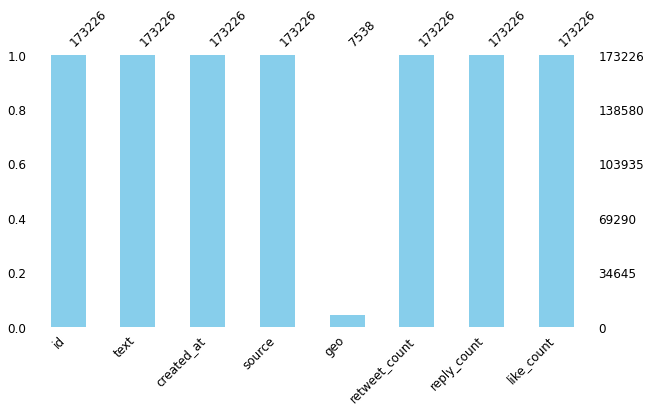

In [482]:
msno.bar(tweets_frame, color="skyblue", figsize=(10,5), fontsize=12)

A dip in geo location data is understandable since several users choose to disable their location while tweeting, so this column is of less significance in tweet analysis. However, Location is given by user while creating twitter account and hence user data frame has location data without missingness.

### Tweets retweet count, like count and reply count trends from 2015 to 2021

In [8]:
%%html
<script type='text/javascript' src='https://prod-useast-b.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1000px; height: 827px;'><object class='tableauViz' width='1000' height='827' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-b.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;shehnazshaikdsa' /><param name='name' value='Retweet_reply_like&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Country distribution of users who tweet about MMIW/P in english.

In [9]:
%%html
<script type='text/javascript' src='https://prod-useast-b.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1252px; height: 874px;'><object class='tableauViz' width='1252' height='874' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-b.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;shehnazshaikdsa' /><param name='name' value='user_locations&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


From the above visualization, we can observe that North America has most users tweeting about MMIW.

In [12]:
%%html
<script type='text/javascript' src='https://prod-useast-b.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1252px; height: 874px;'><object class='tableauViz' width='1252' height='874' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-b.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;shehnazshaikdsa' /><param name='name' value='user_locations&#47;Sheet2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And, Canada has the largest user base tweeting about MMIW followed by USA and UK.

### Word clouds

In [489]:
def wordcloud_by_tweets(tweets):
    stopwords = set(STOPWORDS)
    stopwords.add("MMIWG")
    stopwords.add("t")
    stopwords.add("co")
    stopwords.add("MMIW")
    stopwords.add("HTTPS")
    stopwords.add("CANADA")
    stopwords.add("WILL")
    stopwords.add("client")
    stopwords.add("amp")
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,width=1500, height=1000,random_state = None).generate(" ".join([i for i in tweets.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")

#### Word cloud of tweet text

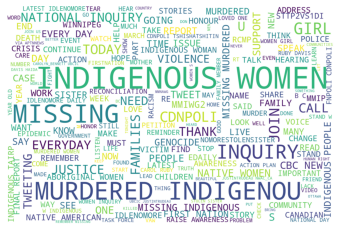

In [491]:
wordcloud_by_tweets(tweets=tweets_frame['text'])  

#### Word cloud of tweet source

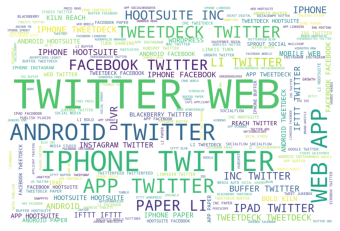

In [490]:
wordcloud_by_tweets(tweets=tweets_frame['source'])  

## Data Preparation

In [4]:
# removes urls 
tweets_frame['clean_text'] = tweets_frame['text'].replace(r'http\S+', ' ', regex=True)

## removing usernames, since they start with @
tweets_frame['clean_text']=tweets_frame['clean_text'].apply(lambda x :[t for t in x.split() if not t.startswith('@')] ).apply(lambda x: ' '.join(x))

## removing special characters and numbers
tweets_frame['clean_text'] = tweets_frame['clean_text'].replace(r'[^A-Za-z]+', ' ', regex=True)

# converts to lowercase
tweets_frame['clean_text']=tweets_frame['clean_text'].str.lower()

# contractions
tweets_frame['clean_text']=tweets_frame['clean_text'].apply(contractions.fix)

## white spaces
tweets_frame['clean_text']=tweets_frame['clean_text'].apply(lambda x : x.strip())

## removing stopwords
stop = stopwords.words('english')
stop.extend(['amp','aaa','mmiw','mmiwg'])

tweets_frame['clean_text'] = tweets_frame['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
tweets_frame['clean_text'].head(15)

0      energy spent lce could gone towards working community strategies celebrating amazing people self care
1                                                      maybe woman understand debasing really b human endvaw
2                                      thing disgusts whole cluster fuck energy attention could gone towards
3                                                             week cbc news launch nationwide special series
4                                                               red fabric starts go vamps placed whitehorse
5              ww worked defunct consulting org worked w police claiming ownership database work last decade
6                                          brutal assault manitoba foster care aboriginal teen fighting life
7                          theland kicknosway km walk run children missing murdered indigenous women cdnpoli
8                          theland kicknosway km walk run children missing murdered indigenous women cdnpoli
9                  

In [5]:
tweets_frame1 = pd.DataFrame()

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
tweets_frame1 = tweets_frame[['text','clean_text']].copy()

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
tweets_frame1

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,clean_text
0,"All the energy spent on LCE could have gone towards working on community strategies for #MMIW, celebrating amazing people or self care.",energy spent lce could gone towards working community strategies celebrating amazing people self care
1,"""Maybe u have to be a woman to understand how debasing this is. Really, u should only have 2b human."" http://t.co/JjuR2hIoNs #MMIW #endVAW",maybe woman understand debasing really b human endvaw
2,"The thing that disgusts me most about this whole cluster fuck, is the energy &amp; attention that could have gone towards #MMIW",thing disgusts whole cluster fuck energy attention could gone towards
3,"""This week, CBC News will launch a nationwide special series on #MMIW"" http://t.co/KsHTWqCFLS",week cbc news launch nationwide special series
4,The red fabric starts to go on. This is where the vamps will be placed. #Whitehorse #MMIW http://t.co/eHABq4pTmt,red fabric starts go vamps placed whitehorse
...,...,...
173221,It's over. @MapleLeafs win in overtime. Meegwetch for the beautiful ceremony honouring Indigeneous nations.\n#Wenjack \n#MMIW \n#IRS,win overtime meegwetch beautiful ceremony honouring indigeneous nations wenjack irs
173222,"This is why the #MMIW inquiry without investigation into police conduct with inherent, systemic racism and sexism... https://t.co/qBBWwA2Tob",inquiry without investigation police conduct inherent systemic racism sexism
173223,The #IdleNoMore &amp; #MMIW eDaily — https://t.co/9PE9bIcvdb || #FNPoli #CdnPoli Tshishatshitin @minez782 @AshCallingbull @AHNnewspaper,idlenomore edaily fnpoli cdnpoli tshishatshitin
173224,"Oh RCMP ""dealt with the complaint"" did they?! No charges have been laid?! #NOJUSTICE had been served #MMIW #Canada https://t.co/S5y1YASljO",oh rcmp dealt complaint charges laid nojustice served canada


##### Dropping Duplicates

In [8]:
tweets_frame1.sort_values('text', ascending=True).drop_duplicates('clean_text').sort_index()

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,clean_text
0,"All the energy spent on LCE could have gone towards working on community strategies for #MMIW, celebrating amazing people or self care.",energy spent lce could gone towards working community strategies celebrating amazing people self care
1,"""Maybe u have to be a woman to understand how debasing this is. Really, u should only have 2b human."" http://t.co/JjuR2hIoNs #MMIW #endVAW",maybe woman understand debasing really b human endvaw
2,"The thing that disgusts me most about this whole cluster fuck, is the energy &amp; attention that could have gone towards #MMIW",thing disgusts whole cluster fuck energy attention could gone towards
3,"""This week, CBC News will launch a nationwide special series on #MMIW"" http://t.co/KsHTWqCFLS",week cbc news launch nationwide special series
4,The red fabric starts to go on. This is where the vamps will be placed. #Whitehorse #MMIW http://t.co/eHABq4pTmt,red fabric starts go vamps placed whitehorse
...,...,...
173219,Officer pleads guilty over 'racist' posts after death of artist #AnniePootoogook - The Globe and Mail https://t.co/wwb1JLtt1P #MMIW,officer pleads guilty racist posts death artist anniepootoogook globe mail
173221,It's over. @MapleLeafs win in overtime. Meegwetch for the beautiful ceremony honouring Indigeneous nations.\n#Wenjack \n#MMIW \n#IRS,win overtime meegwetch beautiful ceremony honouring indigeneous nations wenjack irs
173222,"This is why the #MMIW inquiry without investigation into police conduct with inherent, systemic racism and sexism... https://t.co/qBBWwA2Tob",inquiry without investigation police conduct inherent systemic racism sexism
173224,"Oh RCMP ""dealt with the complaint"" did they?! No charges have been laid?! #NOJUSTICE had been served #MMIW #Canada https://t.co/S5y1YASljO",oh rcmp dealt complaint charges laid nojustice served canada


## Methodology and Techniques

### Sentimental Analysis using TextBlob

In [9]:
# Text sentiment polarity function
def TextPolarity_TB(txt):
    return TextBlob(txt).sentiment.polarity
# Function to assign negative, Neutral and Positive sentiments
def getSentiment(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
tweets_frame1['pScore_TB'] = tweets_frame1['clean_text'].apply(TextPolarity_TB)
tweets_frame1['Sentiment_TB'] = tweets_frame1['pScore_TB'].apply(getSentiment)

### Sentimental Analysis using VADER  ( Valence Aware Dictionary for Sentiment Reasoning)

In [10]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shehn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
def TextPolarity_vader(txt):
    return sid.polarity_scores(txt)

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
import warnings
warnings.filterwarnings('ignore')

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
TextPolarity_vader('Heres what the review of alleged racism in tbay police will look at')

{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'compound': -0.6249}

In [20]:
tweets_frame1['pScore_v'] = tweets_frame1['clean_text'].apply(TextPolarity_vader)
tweets_frame1['score_v'] = tweets_frame1['pScore_v'].apply(lambda dicts: dicts['compound'])
tweets_frame1['Sentiment_v'] = tweets_frame1['score_v'].apply(getSentiment)

In [21]:
tweets_frame1.head(5)

,text,clean_text,pScore_TB,Sentiment_TB,pScore_v,score_v,Sentiment_v
0,"All the energy spent on LCE could have gone towards working on community strategies for #MMIW, celebrating amazing people or self care.",energy spent lce could gone towards working community strategies celebrating amazing people self care,0.250000,Positive,"{'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'compound': 0.9153}",0.9153,Positive
1,"""Maybe u have to be a woman to understand how debasing this is. Really, u should only have 2b human."" http://t.co/JjuR2hIoNs #MMIW #endVAW",maybe woman understand debasing really b human endvaw,0.000000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral
2,"The thing that disgusts me most about this whole cluster fuck, is the energy &amp; attention that could have gone towards #MMIW",thing disgusts whole cluster fuck energy attention could gone towards,-0.100000,Negative,"{'neg': 0.42, 'neu': 0.446, 'pos': 0.134, 'compound': -0.6705}",-0.6705,Negative
3,"""This week, CBC News will launch a nationwide special series on #MMIW"" http://t.co/KsHTWqCFLS",week cbc news launch nationwide special series,0.357143,Positive,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.4019}",0.4019,Positive
4,The red fabric starts to go on. This is where the vamps will be placed. #Whitehorse #MMIW http://t.co/eHABq4pTmt,red fabric starts go vamps placed whitehorse,0.000000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral


Text(0.5, 1.0, 'Sentiment Bar plot using VADER')

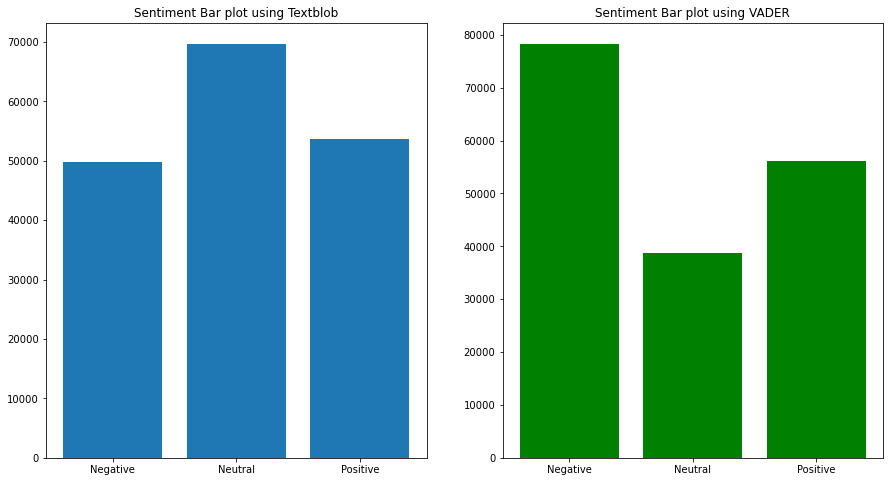

In [22]:
plt.figure(figsize=[15, 8])

plt.subplot(1, 2, 1)
label0 = tweets_frame1.groupby('Sentiment_TB').count().index.values
value0 = tweets_frame1.groupby('Sentiment_TB').size().values
plt.bar(label0, value0)
plt.title('Sentiment Bar plot using Textblob')

plt.subplot(1, 2, 2)
label1 = tweets_frame1.groupby('Sentiment_v').count().index.values
value1 = tweets_frame1.groupby('Sentiment_v').size().values
plt.bar(label1, value1, color='g')
plt.title('Sentiment Bar plot using VADER')

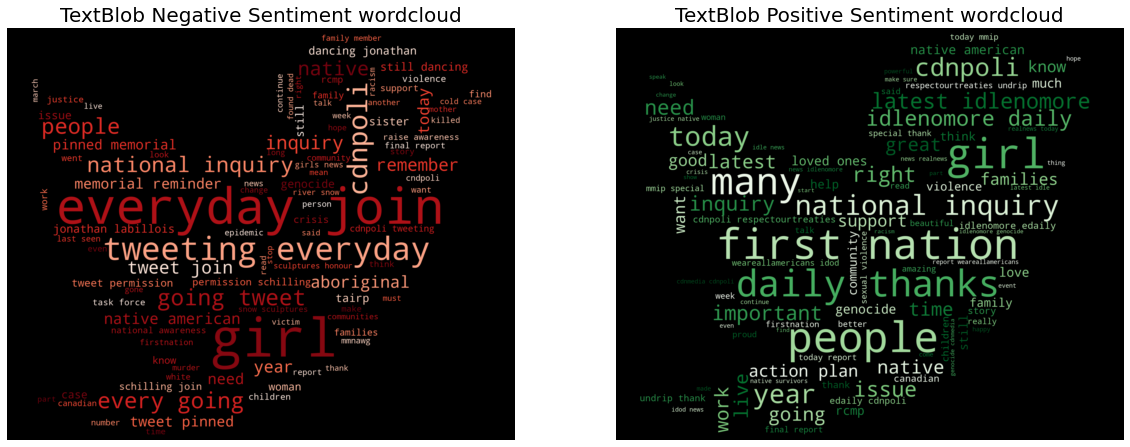

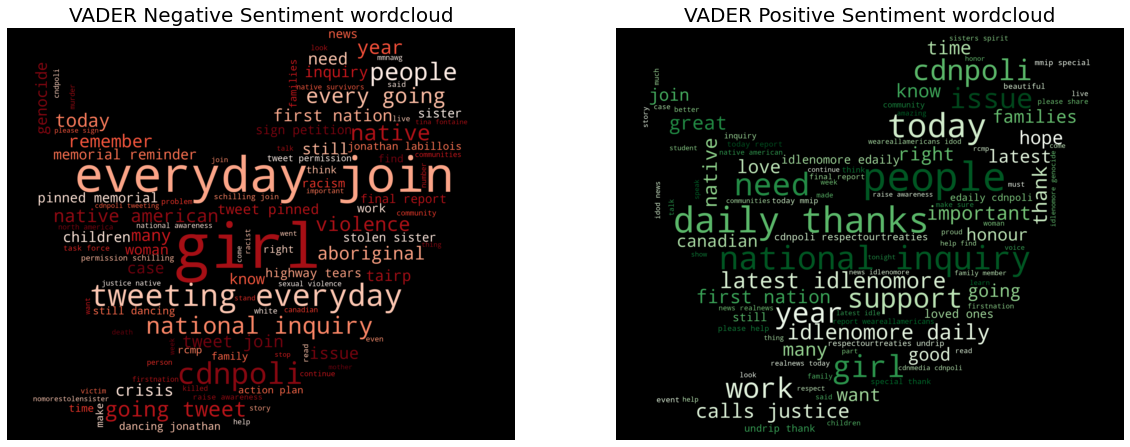

In [555]:
mask=np.array(Image.open('6365467_preview.png'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
stopwords = set(STOPWORDS)
stopwords.update(['mmiw','mmiwg','canada','amp','missing','murdered','indigenous', 'women'])


wordcloud1 = WordCloud(colormap="Reds",min_word_length=4,stopwords=stopwords, width=1500, height=400, max_words=100,
                       collocation_threshold=20, mask=mask).generate(" ".join(tweets_frame1[tweets_frame1['pScore_TB']<0]['clean_text']))
ax1.imshow(wordcloud1,interpolation="bilinear")
ax1.axis('off')
ax1.set_title('TextBlob Negative Sentiment wordcloud',fontsize=20)


wordcloud2 = WordCloud(colormap="Greens",min_word_length=4,stopwords=stopwords, max_words=100,
                       collocation_threshold=20, mask=mask).generate(" ".join(tweets_frame1[tweets_frame1['pScore_TB']>0]['clean_text']))
ax2.imshow(wordcloud2,interpolation="bilinear")
ax2.axis('off')
ax2.set_title('TextBlob Positive Sentiment wordcloud',fontsize=20)
plt.savefig('Senti_TB03.png')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])


wordcloud1 = WordCloud(colormap="Reds",min_word_length=4,stopwords=stopwords, width=1500, height=400, max_words=100,
                       collocation_threshold=20, mask=mask).generate(" ".join(tweets_frame1[tweets_frame1['score_v']<0]['clean_text']))
ax1.imshow(wordcloud1,interpolation="bilinear")
ax1.axis('off')
ax1.set_title('VADER Negative Sentiment wordcloud',fontsize=20)


wordcloud2 = WordCloud(colormap="Greens",min_word_length=4,stopwords=stopwords, max_words=100,
                       collocation_threshold=20, mask=mask).generate(" ".join(tweets_frame1[tweets_frame1['score_v']>0]['clean_text']))
ax2.imshow(wordcloud2,interpolation="bilinear")
ax2.axis('off')
ax2.set_title('VADER Positive Sentiment wordcloud',fontsize=20)
plt.savefig('Senti_V03.png')

### Key Words that are of our interest

This gives us insight with to respect criminal justice challenges and jurisdictional issues using social media posts from associated SM groups looking for loved ones.

In [558]:
# Keywords of Interest
keywords = ['police','court','law','arrest','trial','hearings','legislation']
political_df = pd.DataFrame()
df1 = pd.DataFrame()

In [559]:
# Function For comparison
def keyword_match(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False
def key_count(keyword):
    count = len(tweets_frame1[tweets_frame1['text'].apply(lambda tweet: keyword_match(keyword, tweet))])
    return keyword, count

In [565]:
for every in keywords:
    print(key_count(every))
    df1 = tweets_frame1[tweets_frame1['text'].apply(lambda tweet: keyword_match(every, tweet))]
    political_df = political_df.append(df1)

('police', 6055)
('court', 1640)
('law', 3274)
('arrest', 397)
('trial', 388)
('hearings', 2521)
('legislation', 373)


In [567]:
political_df.sort_values('text', ascending=True).drop_duplicates('clean_text').sort_index()

,text,clean_text,pScore_TB,Sentiment_TB,pScore_v,Sentiment_v,score_v
5,"a ww who worked for a now defunct ""consulting"" org &amp; who worked w police claiming ownership over #mmiw database for work over last decade?!",ww worked defunct consulting org worked w police claiming ownership database work last decade,0.000000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral,0.0000
24,To then throw a hissy fit &amp; quit COV4 bc someone else who was doing work on MMIW is disgusting. #ChiefElkIndustrialComplex,throw hissy fit quit cov bc someone else work disgusting chiefelkindustrialcomplex,-0.300000,Negative,"{'neg': 0.228, 'neu': 0.604, 'pos': 0.168, 'compound': -0.2263}",Negative,-0.2263
39,Media is obsessed w/ Duffy trial &amp; Harper's PMO.Let's remind ourselves there still nothing being done about #MMIW #mmaw not a damned thing.,media obsessed w duffy trial harper pmo let remind still nothing done mmaw damned thing,-0.500000,Negative,"{'neg': 0.107, 'neu': 0.755, 'pos': 0.137, 'compound': 0.124}",Positive,0.1240
43,Political inaction on #MMIW and mistrust of police are part of the reason groups like Drag the Red and @bearclanmb are started says Prof.,political inaction mistrust police part reason groups like drag red started says prof,-0.033333,Negative,"{'neg': 0.238, 'neu': 0.61, 'pos': 0.152, 'compound': -0.1027}",Negative,-0.1027
60,Court's use of remains did not respect Cindy Gladue’s dignity http://t.co/HsvF7lpB60 #CindyGladue #MMIW #MMIW #Duffy #Cdnpoli,court use remains respect cindy gladue dignity cindygladue duffy cdnpoli,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.7003}",Positive,0.7003
...,...,...,...,...,...,...,...
173144,"Ont watchdog probe of Thunder Bay police, to include #MMIW, all indigenous deaths, disappearances https://t.co/xvUHpR9aPD via @torontostar",ont watchdog probe thunder bay police include indigenous deaths disappearances via,0.000000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral,0.0000
173158,Here's what the review of alleged racism in #tbay police will look at. https://t.co/Es88kaZOfM #police #MMIW,review alleged racism tbay police look police,-0.100000,Negative,"{'neg': 0.406, 'neu': 0.594, 'pos': 0.0, 'compound': -0.6249}",Negative,-0.6249
173159,"If requested, the OIPRD will share share its systemic review into TBay Police with the ongoing National Inquiry into #MMIWG",requested oiprd share share systemic review tbay police ongoing national inquiry,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'compound': 0.5267}",Positive,0.5267
173182,.@JustinTrudeau - build a country where all Canadian women feel protected by law enforcement #MMIWG @kotowsa https://t.co/Wfaem6mkuD https://t.co/zXv5LAmvV8,justintrudeau build country canadian women feel protected law enforcement,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.4404}",Positive,0.4404


Now the data frame is ready for text summarizing the tweets that have keywords of opur interest.

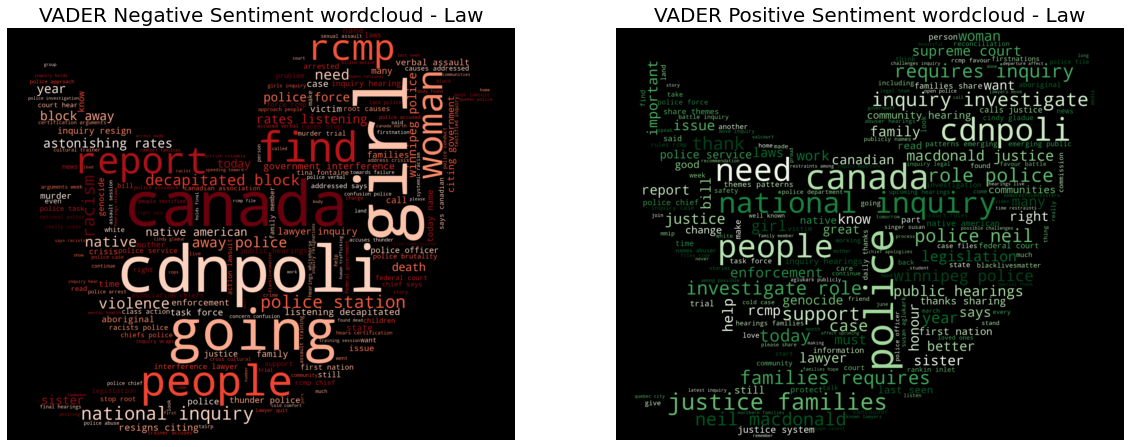

In [569]:
mask=np.array(Image.open('6365467_preview.png'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
stopwords = set(STOPWORDS)
stopwords.update(['mmiw','mmiwg','amp','missing','murdered','indigenous', 'women'])


wordcloud1 = WordCloud(colormap="Reds",min_word_length=4,stopwords=stopwords, width=1500, height=400, 
                       collocation_threshold=20, mask=mask).generate(" ".join(political_df[political_df['score_v']<0]['clean_text']))
ax1.imshow(wordcloud1,interpolation="bilinear")
ax1.axis('off')
ax1.set_title('VADER Negative Sentiment wordcloud - Law',fontsize=20)


wordcloud2 = WordCloud(colormap="Greens",min_word_length=4,stopwords=stopwords,
                       collocation_threshold=20, mask=mask).generate(" ".join(political_df[political_df['score_v']>0]['clean_text']))
ax2.imshow(wordcloud2,interpolation="bilinear")
ax2.axis('off')
ax2.set_title('VADER Positive Sentiment wordcloud - Law',fontsize=20)
plt.savefig('Senti_Vader_political.png')

### Text Summarization with NLTK

In [571]:
def sentence_tokenize(tweet):
    return nltk.sent_tokenize(tweet)

In [655]:
def sent_lists(clean_text):
    return clean_text.tolist()
def token_list(clean_text):
    return clean_text.apply(tokenize_lowercase)
def word_freq(token_list):
    #For word frequencies
    words = [item for sublist in tokens_list for item in sublist]
    word_freq = FreqDist(words)
    #Finding weighted frequencies of each word.
    maximum_frequncy = max(word_freq.values())
    for word in word_freq.keys():
        word_freq[word] = (word_freq[word]/maximum_frequncy)
    return word_freq

In [656]:
def sentence_score(sentence_list, word_freq):
    sentence_scores = {}
    #Calculating the sentence scores
    for sent in sentence_list:
        if word in word_freq.keys():
            if len(sent.split(' ')) < 40:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_freq[word]
                else:
                    sentence_scores[sent] += word_freq[word]
    return sentence_scores  
def get_Summary(sentence_scores):
    summary_sentences = heapq.nlargest(20, sentence_scores, key=sentence_scores.get)
    summary = '. '.join(summary_sentences)
    return summary

### Summary of all cleaned tweets

In [652]:
sentence_list = sent_lists(tweets_frame1['clean_text'])
tokens_list = token_list(tweets_frame1['clean_text'])
word_freq = word_freq(token_list)
sentence_scores = sentence_score(sentence_list, word_freq)
get_Summary(sentence_scores)

'tweeting everyday join missing murdered indigenous women. speak name carol ruby davis haida. stand w indigenous women families call end. missing murdered indigenous women tweet pinned memorial reminder. remember missing murdered indigenous women cdnpoli. idlenomore edaily fnpoli cdnpoli tshishatshitin. every day going tweet join missing murdered indigenous women still dancing jonathan labillois. every day going tweet permission del schilling join missing murdered indigenous women cdnpoli. genocide indigenous women happening right. violence indigenous women silentcrisis must end sign petition support notinvisibleact address national epidemic via. missing murdered indigenous women. joining protect womensrights make sure nativewomen equal access care justice assault vawa. every day going tweet join missing murdered indigenous women cndpoli. conversation murdered missing native women one north america wants must. idlenomore edaily cdnpoli respectourtreaties undrip thanks indigenous. ponca

### Summary involving law, police and legislation related tweets

In [658]:
sentence_list = sent_lists(political_df['clean_text'])
tokens_list = token_list(political_df['clean_text'])
word_freq = word_freq(token_list)
sentence_scores = sentence_score(sentence_list, word_freq)
get_Summary(sentence_scores)

'decapitated block away police station indigenous women going missing astonishing rates one listening. lawyer inquiry resigns citing government interference. justice families requires inquiry investigate role police neil macdonald. investigate without looking police conduct steven zhou writes. got really bad cross cultural trainer accuses thunder bay police verbal assault session. racists police force rcmp chief says. cases stop root causes addressed says canadian association chiefs police cbc ca. families share themes patterns emerging st public hearings. things families missing murdered indigenous women seek public hearings approach. youth suicides inquiry police relations centre afn meeting. hearings would light lack mental health services canada north. concern confusion police approach people testified inquiry cbc news. teen held captive tortured dismissed police runaway case inquiry hears. canada federal court hears certification arguments week lawsuit. national inquiry announces 

### Topic Modeling Using Latent Dirichlet Allocation (LDA)

#### Tokenize

In [574]:
def tokenize_lowercase(text):
    tokens = word_tokenize(text)
    return tokens


In [ ]:
tweets_frame1['tokenized_tweet'] = tweets_frame1['clean_text'].apply(tokenize_lowercase)

#### Lemmatize

In [66]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tweet_text):
    lemmatized =[]
    for w in tweet_text:
        lemmatized.append(lemmatizer.lemmatize(w))
    return lemmatized

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
tweets_frame1['tweet_lemma'] = tweets_frame1['tokenized_tweet'].apply(lemmatize_text)

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
#iterate through each tweet, then each token in each tweet, and store in one list
words = [item for sublist in tweets_frame1['tweet_lemma'] for item in sublist]

word_freq = FreqDist(words)

word_freq.most_common(30)

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('woman', 38848),
 ('indigenous', 34860),
 ('missing', 23912),
 ('inquiry', 20164),
 ('murdered', 18387),
 ('canada', 10341),
 ('family', 10046),
 ('cdnpoli', 9367),
 ('girl', 9021),
 ('native', 7832),
 ('people', 7571),
 ('national', 7451),
 ('today', 6989),
 ('day', 6875),
 ('violence', 6591),
 ('report', 6357),
 ('justice', 5708),
 ('say', 5650),
 ('via', 5603),
 ('one', 5531),
 ('u', 5323),
 ('need', 5112),
 ('year', 4975),
 ('sister', 4495),
 ('call', 4482),
 ('police', 4403),
 ('community', 4096),
 ('please', 4096),
 ('awareness', 4035),
 ('time', 4025)]

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


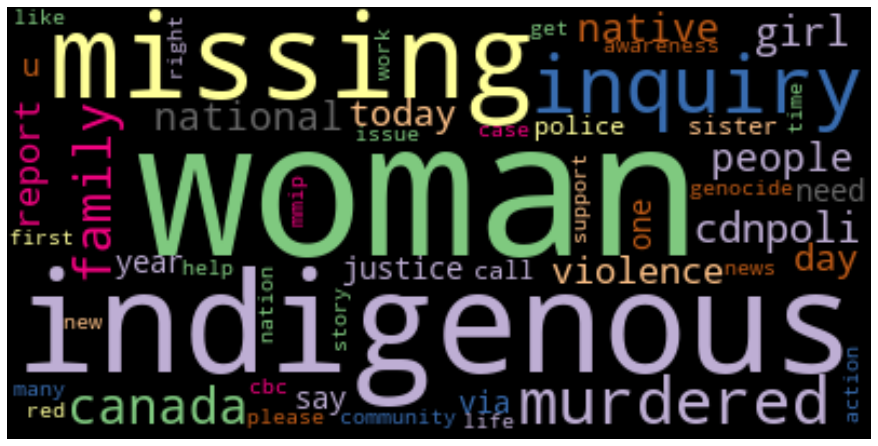

In [113]:
most_common_count = [x[1] for x in word_freq.most_common(50)]
most_common_word = [x[0] for x in word_freq.most_common(50)]

#create dictionary mapping of word count
top_50_dictionary = dict(zip(most_common_word, most_common_count))
#Create Word Cloud of top 50 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_50_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_50_cloud.png')

plt.show()

We see that the terms missing, murdered, indigenous and women are most occuring.

### LDA Model

In [120]:
# Creating Corpus
# first creating a dict of lemmatized words
text_dict = Dictionary(tweets_frame1['tweet_lemma'])
corpus = [text_dict.doc2bow(tweet) for tweet in tweets_frame1['tweet_lemma']]

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
k = 10
tweets_lda = LdaModel(corpus,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=20)

tweets_lda.show_topics()

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.034*"winnipeg" + 0.030*"red" + 0.017*"w" + 0.013*"dress" + 0.012*"include" + 0.011*"n" + 0.011*"consultation" + 0.011*"fed" + 0.011*"carolyn" + 0.010*"project"'),
 (1,
  '0.053*"inquiry" + 0.031*"cbc" + 0.024*"news" + 0.023*"case" + 0.017*"via" + 0.017*"today" + 0.015*"pre" + 0.013*"report" + 0.013*"meeting" + 0.012*"video"'),
 (2,
  '0.054*"family" + 0.030*"one" + 0.020*"found" + 0.014*"name" + 0.013*"say" + 0.012*"inuit" + 0.011*"call" + 0.011*"member" + 0.010*"loved" + 0.010*"year"'),
 (3,
  '0.019*"story" + 0.015*"get" + 0.014*"need" + 0.011*"work" + 0.011*"u" + 0.009*"justice" + 0.008*"see" + 0.008*"make" + 0.008*"let" + 0.008*"racist"'),
 (4,
  '0.024*"thanks" + 0.023*"federal" + 0.019*"idlenomore" + 0.019*"american" + 0.018*"latest" + 0.015*"march" + 0.013*"cdnpoli" + 0.012*"memorial" + 0.011*"could" + 0.011*"vancouver"'),
 (5,
  '0.172*"woman" + 0.118*"indigenous" + 0.101*"missing" + 0.077*"murdered" + 0.031*"girl" + 0.017*"native" + 0.017*"canada" + 0.015*"violence" 

In [124]:
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(tweets_lda, corpus, dictionary=tweets_lda.id2word)
vis

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.106198 -0.061727       1        1  16.670200
6      0.101392 -0.234474       2        1  13.461474
9      0.248518  0.063860       3        1  11.352437
3      0.165946  0.174960       4        1  11.272714
8     -0.131853  0.219604       5        1  10.400312
7      0.069764 -0.210432       6        1   8.963277
2      0.034512  0.162382       7        1   7.795187
1     -0.163735 -0.080056       8        1   7.788713
4     -0.234425 -0.095807       9        1   6.159550
0     -0.196317  0.061690      10        1   6.136137, topic_info=            Term          Freq         Total Category  logprob  loglift
21         woman  44053.000000  44053.000000  Default  30.0000  30.0000
68       missing  25874.000000  25874.000000  Default  29.0000  29.0000
374      inquiry  28049.000000  28049.000000  Default  28.0000  28.0000
65    indigenous  37351.000000  37351.000000  Default  27.0000  27.0000
69      murdered  19786.000000  19786.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1893     bennett    734.673848   1566.274467  Topic10  -4.8571   2.0339
348         meet    633.300906   1157.896761  Topic10  -5.0056   2.1876
274      support    905.401936   3965.055562  Topic10  -4.6481   1.3141
137        today    951.191453   6349.642446  Topic10  -4.5988   0.8925
1096        seen    634.236902   1284.232748  Topic10  -5.0041   2.0855

[523 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
55        1  0.506404  aboriginal
55        2  0.493270  aboriginal
1949      2  0.365175       abuse
1949      6  0.633904       abuse
856       1  0.774986      across
...     ...       ...         ...
106       7  0.237324        year
931       5  0.998702         yeg
302       4  0.998878         yet
439       8  0.998695         yqr
575       5  0.997767         yxe

[670 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 10, 4, 9, 8, 3, 2, 5, 1])

In [127]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=tweets_lda, texts=tweets_frame1['tweet_lemma'], dictionary=text_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\ncv Coherence Score: ', coherence_lda)

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.3323997964268537


In [128]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=tweets_lda, texts=tweets_frame1['tweet_lemma'], dictionary=text_dict, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\n uMass Coherence Score: ', coherence_lda)

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



 uMass Coherence Score:  -4.7294759902142065


In [129]:
def compute_coherence_values(text_dict, corpus, tweets, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=text_dict, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tweets, dictionary=text_dict, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


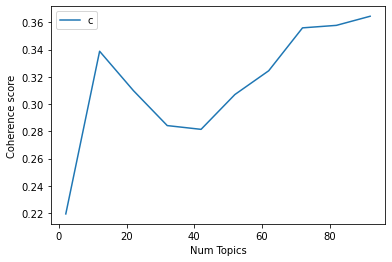

In [131]:
model_list, coherence_values = compute_coherence_values(text_dict, corpus, tweets=tweets_frame1['tweet_lemma'], start=2, limit=100, step=10)
# Show graph
import matplotlib.pyplot as plt
limit=100; start=2; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [135]:
k = 15
tweets_lda1 = LdaModel(corpus,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=25)

tweets_lda1.show_topics()

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(4,
  '0.073*"cdnpoli" + 0.047*"minister" + 0.033*"native" + 0.032*"thanks" + 0.030*"firstnations" + 0.026*"american" + 0.025*"idlenomore" + 0.024*"genocide" + 0.024*"latest" + 0.021*"racist"'),
 (2,
  '0.230*"inquiry" + 0.045*"national" + 0.035*"call" + 0.031*"say" + 0.030*"cdnpoli" + 0.027*"report" + 0.023*"government" + 0.020*"action" + 0.017*"family" + 0.017*"trudeau"'),
 (14,
  '0.032*"people" + 0.026*"want" + 0.026*"many" + 0.025*"know" + 0.025*"need" + 0.021*"get" + 0.021*"like" + 0.019*"go" + 0.019*"family" + 0.017*"stop"'),
 (5,
  '0.222*"woman" + 0.178*"indigenous" + 0.116*"missing" + 0.100*"murdered" + 0.041*"girl" + 0.021*"canada" + 0.018*"violence" + 0.018*"native" + 0.016*"aboriginal" + 0.010*"people"'),
 (3,
  '0.027*"w" + 0.024*"last" + 0.023*"look" + 0.022*"week" + 0.017*"talk" + 0.017*"next" + 0.016*"work" + 0.015*"great" + 0.015*"seen" + 0.015*"take"'),
 (6,
  '0.026*"still" + 0.026*"pre" + 0.025*"nomorestolensisters" + 0.021*"cdnpoli" + 0.021*"care" + 0.019*"medium

In [136]:
pyLDAvis.enable_notebook()

vis1 = gensimvis.prepare(tweets_lda1, corpus, dictionary=tweets_lda.id2word)
vis1

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.112525  0.147479       1        1  13.931904
14    -0.050341  0.257799       2        1   8.649622
2      0.151644 -0.013665       3        1   8.406717
10    -0.192573  0.120279       4        1   7.283475
3     -0.106117  0.036242       5        1   6.371915
11    -0.038677 -0.031684       6        1   6.290402
7      0.253370 -0.047505       7        1   6.195488
8     -0.180964 -0.010048       8        1   5.854058
6      0.100961  0.024621       9        1   5.749724
0     -0.134745 -0.074545      10        1   5.635040
12     0.062003  0.208119      11        1   5.588395
1     -0.147445 -0.176033      12        1   5.322282
4      0.173039 -0.118519      13        1   5.133398
9      0.050929 -0.131205      14        1   4.953996
13    -0.053608 -0.191334      15        1   4.633585, topic_info=            Term          Freq         Total Category  logprob  loglift
21         woman  47594.000000  47594.000000  Default  30.0000  30.0000
374      inquiry  29847.000000  29847.000000  Default  29.0000  29.0000
65    indigenous  41729.000000  41729.000000  Default  28.0000  28.0000
68       missing  27842.000000  27842.000000  Default  27.0000  27.0000
69      murdered  21424.000000  21424.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
2306        camp    543.687095    545.005425  Topic15  -4.8773   3.0694
333         read   2170.951002   2947.638561  Topic15  -3.4927   2.7660
187    important   1916.066369   2748.983719  Topic15  -3.6176   2.7109
326          man   1111.947533   1870.071513  Topic15  -4.1618   2.5520
1297       share    613.934251   2738.942765  Topic15  -4.7558   1.5764

[676 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
55        1  0.626812  aboriginal
55        6  0.140724  aboriginal
55        7  0.129511  aboriginal
55       11  0.102787  aboriginal
1949      7  0.999350       abuse
...     ...       ...         ...
1117      6  0.999089       young
168       5  0.816661       youth
168      14  0.182342       youth
439       6  0.997904         yqr
1161     14  0.997266       yukon

[824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 15, 3, 11, 4, 12, 8, 9, 7, 1, 13, 2, 5, 10, 14])

### Topic Modeling Using Non-Negative matric Factorization (NMF)

In [137]:
## Creating document term matrix using TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english',ngram_range=(1,2))
dt_matrix = tfidf.fit_transform(tweets_frame1['clean_text'])

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
# creating NMF model with 10 components

nmf_model = NMF(n_components=10,random_state=42)

# fitting and transforming matrix obtained,
# to get weights corresponding to belongingness of the document to each topic

topics=nmf_model.fit_transform(dt_matrix)

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [139]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


THE TOP 10 WORDS FOR TOPIC #0
['murdered women', 'women inquiry', 'inquiry missing', 'indigenous', 'women', 'indigenous women', 'murdered indigenous', 'missing', 'missing murdered', 'murdered']


THE TOP 10 WORDS FOR TOPIC #1
['commissioner', 'final', 'says', 'hearings', 'report', 'families', 'inquiry missing', 'national inquiry', 'national', 'inquiry']


THE TOP 10 WORDS FOR TOPIC #2
['women rights', 'rights daily', 'latest indigenous', 'idlenomore', 'idlenomore daily', 'latest idlenomore', 'daily thanks', 'thanks', 'daily', 'latest']


THE TOP 10 WORDS FOR TOPIC #3
['women', 'human', 'racism', 'rights', 'people', 'women canada', 'indigenous', 'report', 'genocide', 'canada']


THE TOP 10 WORDS FOR TOPIC #4
['support', 'nomorestolensisters', 'justice', 'today', 'red', 'families', 'help', 'sisters', 'awareness', 'day']


THE TOP 10 WORDS FOR TOPIC #5
['honour', 'murdered missing', 'missing indigenous', 'violence indigenous', 'violence', 'indigenous', 'indigenous women', 'women', 'women 

As NMF is a deterministic model, we don’t have a way to modify the probabilities to see how the key terms vary within each topic. For better Topic coherence, we can try a probabilistic model like LDA.

In [ ]:
naming={0:'MMIW',1:'National_Inquiry_hearings',2:'women_rights',3:'family_end_violence',4:'racism_genocide',
        5:'honor_mmiw',6:'genocide_national_inquiry', 7:'CA_politics_Tweet_Everyday',8:'MMIW_violence',9:'CA_politics'}


In [ ]:
Topic_df = pd.DataFrame()
Topic_df['Topic'] = topics.argmax(axis=1)
Topic_df['Tweet_Text'] = tweets_frame1['text']
Topic_df['Topic_Name'] = Topic_df['Topic'].map(naming) 

In [ ]:
Topic_df[['Tweet_Text','Topic_Name']].head(15)